# Confounding Example: Finding causal effects from observed data

Suppose you are given some data with treatment and outcome. Can you determine whether the treatment causes the outcome, or the correlation is purely due to another common cause?

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import dowhy
from dowhy import CausalModel
import dowhy.datasets, dowhy.plotter

from plotnine import ggplot, aes, geom_line, theme_bw



## Let's create a mystery dataset for which we need to determine whether there is a causal effect.

Creating the dataset. It is generated from either one of two models:
* **Model 1**: Treatment does cause outcome. 
* **Model 2**: Treatment does not cause outcome. All observed correlation is due to a common cause.

No handles with labels found to put in legend.


   ice-cream   swimming        w0      Time
0   9.729339  19.420361  3.804214  9.793602
1   2.868538   5.604283 -3.298684  6.162554
2   9.792647  20.039702  3.993202  2.917549
3   3.330417   6.590135 -2.649071  8.162295
4   4.238493   8.308467 -1.562001  0.641611


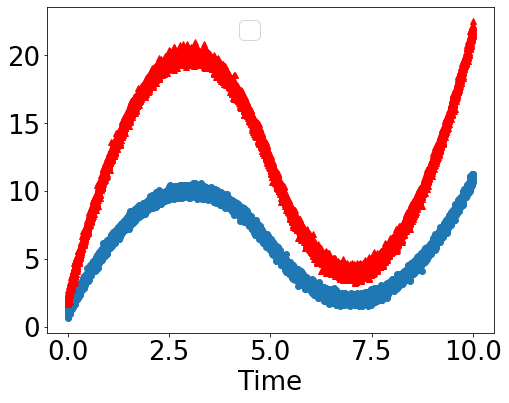

In [39]:
rvar = 1 if np.random.uniform() >0.5 else 0
data_dict = dowhy.datasets.xy_dataset(10000, effect=rvar, sd_error=0.2)                                               
df = data_dict['df'] 
dowhy.plotter.plot_treatment_outcome(df[data_dict["treatment_name"]], df[data_dict["outcome_name"]],
                             df[data_dict["time_val"]]) 

df = df.rename(columns={"Treatment":"ice-cream", "Outcome":"swimming", 
                       "s": "Time"})
print(df.head())                                                                                                     
                                                                                                                                                                                                         

In [47]:

# for plotting, wide to long
plot_df = df.melt(id_vars="Time", value_vars=["ice-cream", "swimming"],
                 var_name="Search Query", value_name="Number of Searches")
print(plot_df.head())
plot = (ggplot(plot_df, aes(x="Time",y="Number of Searches",color="Search Query")) + 
 geom_line()+
 theme_bw())
plot.save('icecream-swimming-timeseries.pdf', height=6, width=8)



       Time Search Query  Number of Searches
0  9.793602    ice-cream            9.729339
1  6.162554    ice-cream            2.868538
2  2.917549    ice-cream            9.792647
3  8.162295    ice-cream            3.330417
4  0.641611    ice-cream            4.238493


/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 8 x 6 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: icecream-swimming-timeseries.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


## Using DoWhy to resolve the mystery: *Does Treatment cause Outcome?*
### STEP 1: Model the problem as a causal graph
Initializing the causal model.

In [5]:
model= CausalModel(                                                                                                                      
        data=df,                                                                                                                         
        treatment=data_dict["treatment_name"],                                                                                           
        outcome=data_dict["outcome_name"],                                                                                               
        common_causes=data_dict["common_causes_names"],                                                                                  
        instruments=data_dict["instrument_names"])                                                                                       
model.view_model(layout="dot")                                                                                                                                                                                                                                             

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Treatment'] on outcome ['Outcome']


Showing the causal model stored in the local file "causal_model.png"

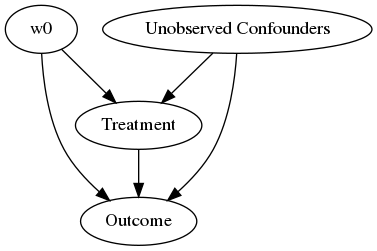

In [6]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

### STEP 2: Identify causal effect using properties of the formal causal graph
Identify the causal effect using properties of the causal graph.

In [7]:
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['w0', 'U']


WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                               
────────────(Expectation(Outcome|w0))
d[Treatment]                         
Estimand assumption 1, Unconfoundedness: If U→{Treatment} and U→Outcome then P(Outcome|Treatment,w0,U) = P(Outcome|Treatment,w0)
### Estimand : 2
Estimand name: iv
No such variable found!



### STEP 3: Estimate the causal effect

Once we have identified the estimand, we can use any statistical method to estimate the causal effect. 

Let's use Linear Regression for simplicity.

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0


Causal Estimate is 1.0154712956668286


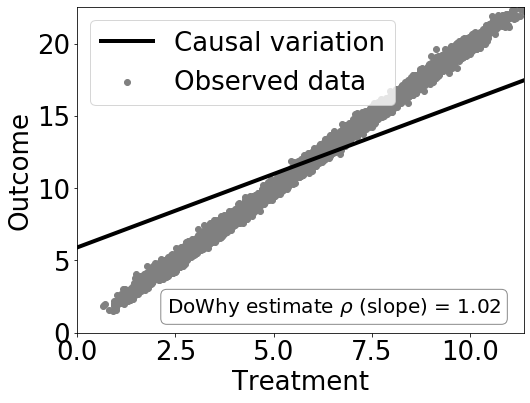

In [8]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print("Causal Estimate is " + str(estimate.value))

# Plot Slope of line between treamtent and outcome =causal effect                                                                                                 
dowhy.plotter.plot_causal_effect(estimate, df[data_dict["treatment_name"]], df[data_dict["outcome_name"]])

### Checking if the estimate is correct

In [9]:
print("DoWhy estimate is " + str(estimate.value)) 
print ("Actual true causal effect was {0}".format(rvar))

DoWhy estimate is 1.0154712956668286
Actual true causal effect was 1


### Step 4: Refuting the estimate

We can also refute the estimate to check its robustness to assumptions (*aka* sensitivity analysis, but on steroids). 

### Adding a random common cause variable

In [10]:
res_random=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_random)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0+w_random


Refute: Add a Random Common Cause
Estimated effect:(1.0154712956668286,)
New effect:(1.01547620948807,)



### Replacing treatment with a random (placebo) variable

In [11]:
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0


Refute: Use a Placebo Treatment
Estimated effect:(1.0154712956668286,)
New effect:(-0.001212143363314766,)



### Removing a random subset of the data

In [12]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)


INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0


Refute: Use a subset of data
Estimated effect:(1.0154712956668286,)
New effect:(1.02452210674865,)



As you can see, our causal estimator is robust to simple refutations.